Notebook to implement spinning of icospheres




In [1]:
#ico class
import os
import numpy as np
import nibabel as nb
import copy
from scipy import sparse 
import meld_classifier.mesh_tools as mt
import torch
from math import pi 
import logging
from meld_graph.icospheres import IcoSpheres
import matplotlib_surface_plotting as msp
from scipy.stats import special_ortho_group
from scipy.spatial import cKDTree

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1
Setting FS_SUBJECTS_PATH to 


In [7]:
def spinning_coords(coords):
    rotation = special_ortho_group.rvs(3)
    new_coords = coords @ rotation
    return new_coords

def barycentric_coordinates_matrix(p,tri):
    #solve to return coordinates as barycentric from 3 vertices of triangle.
        #Use outputs for linear interpolation
        a = (np.square(tri[:,0,0]-tri[:,2,0]) + np.square(tri[:,0,1]-tri[:,2,1]) + np.square(tri[:,0,2]-tri[:,2,2]))
        b = (tri[:,1,0]-tri[:,2,0])*(tri[:,0,0]-tri[:,2,0]) + (tri[:,1,1]-tri[:,2,1])*(tri[:,0,1]-tri[:,2,1]) + (tri[:,1,2]-tri[:,2,2])*(tri[:,0,2]-tri[:,2,2])
        c = b
        d = (np.square(tri[:,1,0]-tri[:,2,0]) + np.square(tri[:,1,1]-tri[:,2,1]) + np.square(tri[:,1,2]-tri[:,2,2]))
        f = (p[:,0] - tri[:,2,0])*(tri[:,0,0]-tri[:,2,0]) + (p[:,1]-tri[:,2,1])*(tri[:,0,1]-tri[:,2,1]) + (p[:,2]-tri[:,2,2])*(tri[:,0,2]-tri[:,2,2])
        g = (p[:,0] - tri[:,2,0])*(tri[:,1,0]-tri[:,2,0]) + (p[:,1]-tri[:,2,1])*(tri[:,1,1]-tri[:,2,1]) + (p[:,2]-tri[:,2,2])*(tri[:,1,2]-tri[:,2,2])
        chi = (d*f - b*g)/(a*d - b*c)
        eta = (-c*f + a*g)/(a*d - b*c)
        lambda1 = chi
        lambda2 = eta
        lambda3 = 1 - chi - eta
        return np.vstack((lambda1, lambda2, lambda3)).T

In [3]:
# Create icospheres
icos=IcoSpheres(conv_type='SpiralConv')

In [5]:
# Select icosphere
ico_index=7
ico_ini = icos.icospheres[ico_index]

# Spin icosphere
ico_spinned = copy.deepcopy(ico_ini)
ico_spinned['coords']=spinning_coords(ico_ini['coords'])


In [8]:
# find nearest 3 neighbours vertices from spinned ico for each vertices in initial ico
tree=cKDTree(ico_spinned['coords'])
distance, indices=tree.query(ico_ini['coords'],k=3)


# find lambda1, lambda2, lambda3, vectors values for barycentric
#https://github.com/kwagstyl/VAST/blob/afed4c2ce4d24a1be49538b13223cbda8f7e75a5/vast/surface_volume_mapper.py#L456
lambdas = barycentric_coordinates_matrix(ico_ini['coords'],ico_spinned['coords'][indices])


In [9]:
#apply to features

#create fake lesion
colors = np.zeros(len(ico_ini['coords']))
neighbours = icos.get_neighbours(level = 7)
lesion_ind = neighbours[100]
colors[lesion_ind]=1

colors_spinned = lambdas[:,0]*colors[indices[:,0]] + lambdas[:,1]*colors[indices[:,1]] + lambdas[:,2]*colors[indices[:,2]]

In [10]:
#if lesion
colors_spinned = np.round(colors_spinned)

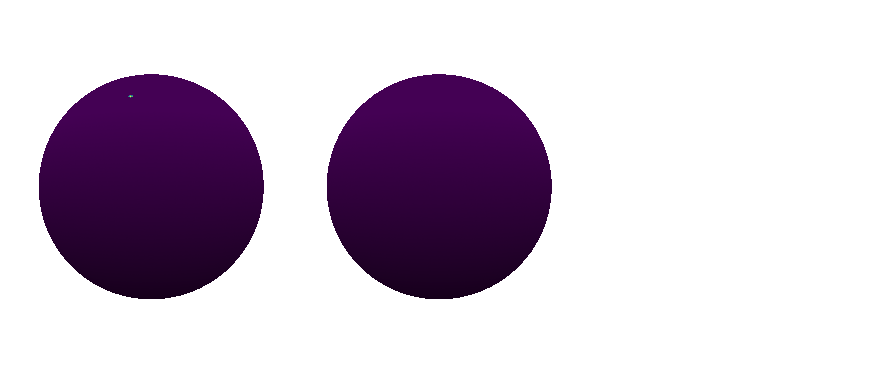

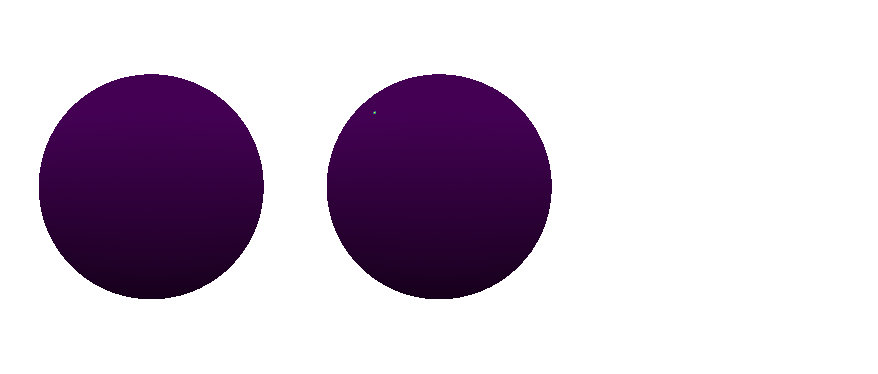

In [11]:
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              colors,
              colorbar=False
                 )

# Plot spinned icosphere
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              colors_spinned, 
              colorbar=False
                 )

In [37]:
#save
data_dir='/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'
data=(lambdas,indices)
np.save(data_dir,data)

In [41]:
data_dir='/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'
a,b= np.load(data_dir)

In [2]:
### test class augment
from meld_graph.augment import Augment

#create fake lesion
icos=IcoSpheres(conv_type='SpiralConv')
ico_index=7
ico_ini = icos.icospheres[ico_index]

lesion = np.zeros(len(ico_ini['coords']))
neighbours = icos.get_neighbours(level = 7)
lesion_ind = neighbours[100]
lesion[lesion_ind]=1

# initiate params
params = {'spinning':
                  {'p': 0.3,
                  'file': '/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/data/spinning/spinning_ico7_10.npy'
                  }
            }
augment = Augment(params)

spinned_lesion = augment.apply(lesion)


In [3]:
spinned_lesion

array([0., 0., 0., ..., 0., 0., 0.])